In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

/home/iiitb_micron/anaconda3/envs/maskplace_gnn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class CircuitTrainingModel(nn.Module):
    EPSILON = 1e-6

    def __init__(
            self, 
            num_gcn_layers=3, 
            edge_fc_layers=1,
            macro_features_dim=4, 
            gcn_node_dim=32, 
            max_macro_num=100,
            include_min_max_var=True, 
            is_augmented=False):
        
        super(CircuitTrainingModel, self).__init__()
        self.num_gcn_layers = num_gcn_layers
        self.gcn_node_dim = gcn_node_dim
        self.include_min_max_var = include_min_max_var
        self.is_augmented = is_augmented
        self.max_macro_num = max_macro_num
        self.macro_features_dim = macro_features_dim

        self.metadata_encoder = nn.Sequential(
            nn.Linear(self.gcn_node_dim, self.gcn_node_dim),
            nn.ReLU()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(self.macro_features_dim, self.gcn_node_dim),
            nn.ReLU()
        )

        self.edge_fc_list = nn.ModuleList([
            self.create_edge_fc(edge_fc_layers) for _ in range(num_gcn_layers)
        ])

        self.attention_layer = nn.MultiheadAttention(embed_dim=self.gcn_node_dim, num_heads=1)
        self.attention_query_layer = nn.Linear(self.gcn_node_dim, self.gcn_node_dim)
        self.attention_key_layer = nn.Linear(self.gcn_node_dim, self.gcn_node_dim)
        self.attention_value_layer = nn.Linear(self.gcn_node_dim, self.gcn_node_dim)

        self.value_head = nn.Sequential(
            nn.Linear(self.gcn_node_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

        if self.is_augmented:
            self.augmented_embedding_layer = nn.Linear(self.gcn_node_dim, self.gcn_node_dim)

    def create_edge_fc(self, edge_fc_layers):
        layers = []
        layers.append(nn.Linear(2*self.gcn_node_dim+1, self.gcn_node_dim))
        layers.append(nn.ReLU())
        for _ in range(edge_fc_layers-1):
            layers.append(nn.Linear(self.gcn_node_dim, self.gcn_node_dim))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    # def gather_to_edges(self, h_nodes, sparse_adj_i, sparse_adj_j, sparse_adj_weight):
    #     print(h_nodes.size(), sparse_adj_i.size(), sparse_adj_j.size(), sparse_adj_weight.size())
    #     h_edges_1 = h_nodes[sparse_adj_i].squeeze(0)
    #     h_edges_2 = h_nodes[sparse_adj_j].squeeze(0)
    #     sparse_adj_weight = sparse_adj_weight.unsqueeze(-1).squeeze(0)
    #     print(h_edges_1.size(), h_edges_2.size(), sparse_adj_weight.unsqueeze(0).size())
    #     h_edges_12 = torch.cat([h_edges_1, h_edges_2, sparse_adj_weight.unsqueeze(0)], dim=-1)
    #     h_edges_21 = torch.cat([h_edges_2, h_edges_1, sparse_adj_weight.unsqueeze(0)], dim=-1)
    #     mask = sparse_adj_weight != 0.0
    #     h_edges_i_j = torch.where(mask, h_edges_12, torch.zeros_like(h_edges_12))
    #     h_edges_j_i = torch.where(mask, h_edges_21, torch.zeros_like(h_edges_21))
    #     return h_edges_i_j, h_edges_j_i

    def gather_to_edges(self, h_nodes, sparse_adj_i, sparse_adj_j, sparse_adj_weight):
    # Print the sizes of the inputs for debugging
        # print(h_nodes.size(), sparse_adj_i.size(), sparse_adj_j.size(), sparse_adj_weight.size())

        # Gather node features for the edges
        h_edges_1 = h_nodes.gather(1, sparse_adj_i.unsqueeze(-1).expand(-1, -1, h_nodes.size(-1)))
        h_edges_2 = h_nodes.gather(1, sparse_adj_j.unsqueeze(-1).expand(-1, -1, h_nodes.size(-1)))

        # Adjust the sparse adjacency weights
        sparse_adj_weight = sparse_adj_weight.unsqueeze(-1)

        # Print the sizes of the gathered edges and adjusted weights for debugging
        # print(h_edges_1.size(), h_edges_2.size(), sparse_adj_weight.size())

        # Concatenate the gathered node features and weights
        h_edges_12 = torch.cat([h_edges_1, h_edges_2, sparse_adj_weight], dim=-1)
        h_edges_21 = torch.cat([h_edges_2, h_edges_1, sparse_adj_weight], dim=-1)

        # Create a mask for non-zero weights
        mask = sparse_adj_weight.squeeze(-1) != 0.0

        # Apply the mask to the concatenated edges
        h_edges_i_j = torch.where(mask.unsqueeze(-1), h_edges_12, torch.zeros_like(h_edges_12))
        h_edges_j_i = torch.where(mask.unsqueeze(-1), h_edges_21, torch.zeros_like(h_edges_21))

        return h_edges_i_j, h_edges_j_i

    # def _scatter_count(self, edge_h, indices, num_nodes):
    #     h_node = torch.zeros(edge_h.size(0), num_nodes, edge_h.size(-1)).to(edge_h.device)
    #     count_edge = torch.zeros_like(h_node)
    #     count = torch.ones_like(edge_h)

    #     idx = indices.unsqueeze(-1).expand_as(edge_h)
    #     h_node.scatter_add_(1, idx, edge_h)
    #     count_edge.scatter_add_(1, idx, count)

    #     return h_node, count_edge

    # def scatter_to_nodes(self, h_edges, sparse_adj_i, sparse_adj_j, num_nodes):
    #     print("scatter ", h_edges.size(), sparse_adj_i.size(), sparse_adj_j.size(), num_nodes)
    #     h_nodes_1, count_1 = self._scatter_count(h_edges, sparse_adj_i, num_nodes)
    #     h_nodes_2, count_2 = self._scatter_count(h_edges, sparse_adj_j, num_nodes)
    #     return (h_nodes_1 + h_nodes_2) / (count_1 + count_2 + self.EPSILON)

    def scatter_to_nodes(self, h_edges, sparse_adj_i, sparse_adj_j, num_nodes):
        batch_size, num_edges, feature_dim = h_edges.size()
        max_num_nodes = self.max_macro_num  
        
        h_nodes_1 = torch.zeros(batch_size, max_num_nodes, feature_dim, device=h_edges.device)
        count_1 = torch.zeros(batch_size, max_num_nodes, device=h_edges.device)
        
        h_nodes_2 = torch.zeros(batch_size, max_num_nodes, feature_dim, device=h_edges.device)
        count_2 = torch.zeros(batch_size, max_num_nodes, device=h_edges.device)

        for b in range(batch_size):
            h_nodes_1[b].index_add_(0, sparse_adj_i[b], h_edges[b])
            count_1[b].index_add_(0, sparse_adj_i[b], torch.ones_like(sparse_adj_i[b], dtype=torch.float, device=h_edges.device))

        for b in range(batch_size):
            h_nodes_2[b].index_add_(0, sparse_adj_j[b], h_edges[b])
            count_2[b].index_add_(0, sparse_adj_j[b], torch.ones_like(sparse_adj_j[b], dtype=torch.float, device=h_edges.device))

        h_nodes = (h_nodes_1 + h_nodes_2) / (count_1.unsqueeze(-1) + count_2.unsqueeze(-1) + self.EPSILON)

        return h_nodes


    def forward(self, inputs):
        # Assuming inputs contain the necessary tensors
        # Replace the actual data with your tensor data

        # Example placeholders:
        sparse_adj_i = inputs['sparse_adj_i']
        sparse_adj_j = inputs['sparse_adj_j']
        sparse_adj_weight = inputs['sparse_adj_weight']
        node_features = inputs['node_features']

        # h_metadata = self.metadata_encoder(netlist_metadata)
        h_nodes = self.feature_encoder(node_features)
        for i in range(self.num_gcn_layers):
            # print(h_nodes.shape)
            h_edges_i_j, h_edges_j_i = self.gather_to_edges(h_nodes, sparse_adj_i, sparse_adj_j, sparse_adj_weight)
            # print(h_edges_i_j.shape, h_edges_j_i.shape)
            h_edges = (self.edge_fc_list[i](h_edges_i_j) + self.edge_fc_list[i](h_edges_j_i)) / 2.0
            h_nodes_new = self.scatter_to_nodes(h_edges, sparse_adj_i, sparse_adj_j, inputs['num_nodes'])
            h_nodes = h_nodes_new + h_nodes
            # print(h_nodes.shape, h_nodes_new.shape)

        return h_nodes, h_edges

# Example usage
model = CircuitTrainingModel(max_macro_num=4, macro_features_dim=4)
inputs = {
    'sparse_adj_i': torch.tensor([[0, 1, 2, 2, 3]]),
    'sparse_adj_j': torch.tensor([[1, 2, 0, 3, 0]]),
    'sparse_adj_weight': torch.rand(1, 5),
    'node_features': torch.tensor([[
        [1.0, 2.0, 3.0, 4.0], 
        [3.0, 4.0, 5.0, 6.0], 
        [5.0, 6.0, 7.0, 8.0], 
        [7.0, 8.0, 9.0, 10.0]]]),
    'num_nodes': torch.tensor([4])
}
inputs2 = {
    'sparse_adj_i': torch.randint(0, 4, (32, 5)),
    'sparse_adj_j': torch.randint(0, 4, (32, 5)),
    'sparse_adj_weight': torch.rand(32, 5),
    'node_features': torch.rand(32, 4, 4),
    'num_nodes': torch.fill_(torch.zeros(32), 4).long()
}
print(inputs2['sparse_adj_j'].size())
print(inputs2['sparse_adj_i'].size())
print(inputs2['sparse_adj_weight'].size())
print(inputs2['node_features'].size())
print(inputs2['num_nodes'].size())
output = model(inputs2)
# print(output[1])
# print(output[0].shape, output[1].shape)
# print(torch.concat([output[0], output[1]], dim=1).shape)

torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 5])
torch.Size([32, 4, 4])
torch.Size([32])


In [3]:
import pandas as pd

df = pd.read_csv('../src/dataset1_backup.csv')

In [4]:
# evaluate each entry in the df to python object
df['Macros_eval'] = df['Macros'].apply(lambda x: eval(x))
df['Netlist_eval'] = df['Netlist'].apply(lambda x: eval(x))
df['HPWL_eval'] = df['HPWL'].apply(lambda x: eval(x))

In [5]:
df.head(1), len(df)

(                                              Macros  \
 0  [(127, 112, 94.44444444444444, 76.458909106537...   
 
                                              Netlist  \
 0  [(0, 65), (1, 12), (2, 25), (2, 54), (3, 73), ...   
 
                                                 HPWL  \
 0  [1915.1460750437332, 1068.4398678656062, 1378....   
 
                                          Macros_eval  \
 0  [(127, 112, 94.44444444444444, 76.458909106537...   
 
                                         Netlist_eval  \
 0  [(0, 65), (1, 12), (2, 25), (2, 54), (3, 73), ...   
 
                                            HPWL_eval  
 0  [1915.1460750437332, 1068.4398678656062, 1378....  ,
 1968)

In [6]:
PADDING_SIZE = 105

df['sparse_adj_i'] = df['Netlist_eval'].apply(lambda x: torch.tensor(x)[:, 0])
# pad other entries of this tensor till PADDING_SIZE
df['sparse_adj_i'] = df['sparse_adj_i'].apply(lambda x: F.pad(x, (0, PADDING_SIZE - len(x))))
# df['num_nodes'] = df['Macros_eval'].apply(lambda x: torch.tensor(PADDING_SIZE))
df['num_nodes'] = df['Macros_eval'].apply(lambda x: torch.tensor(len(x)))
df['sparse_adj_j'] = df['Netlist_eval'].apply(lambda x: torch.tensor(x)[:, 1])
df['sparse_adj_j'] = df['sparse_adj_j'].apply(lambda x: F.pad(x, (0, PADDING_SIZE - len(x))))
df['sparse_adj_weight'] = df['HPWL_eval'].apply(lambda x: torch.tensor(x))
df['sparse_adj_weight'] = df['sparse_adj_weight'].apply(lambda x: F.pad(x, (0, PADDING_SIZE - len(x))))
df['node_features'] = df['Macros_eval'].apply(lambda x : torch.tensor(x))
df['node_features'] = df['node_features'].apply(lambda x: F.pad(x, (0, 0, 0, PADDING_SIZE - len(x))))
df['total_hpwl'] = df['HPWL_eval'].apply(lambda x: torch.tensor(x).sum())

In [7]:
# normalize the column 
mean_val = torch.tensor(df['total_hpwl']).mean()
std_val = torch.tensor(df['total_hpwl']).std()
df['total_hpwl'] = df['total_hpwl'].apply(lambda x: (x - mean_val) / std_val)
df['total_hpwl'][0]

tensor(-0.4628)

In [8]:
class GraphDatase(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # print(idx)
        return {
            'sparse_adj_i': self.df.iloc[idx]['sparse_adj_i'],
            'sparse_adj_j': self.df.iloc[idx]['sparse_adj_j'],
            'sparse_adj_weight': self.df.iloc[idx]['sparse_adj_weight'],
            'node_features': self.df.iloc[idx]['node_features'],
            'num_nodes': self.df.iloc[idx]['num_nodes'],
            'total_hpwl': self.df.iloc[idx]['total_hpwl']
        }

In [9]:
class GCN(nn.Module):
    def __init__(self, GCN_model):
        super(GCN, self).__init__()
        self.gcn_model = GCN_model
        self.gcn_conv = nn.Conv1d(in_channels=self.gcn_model.gcn_node_dim, out_channels=1, kernel_size=1)
        self.linear1 = nn.Linear(2 * self.gcn_model.max_macro_num, self.gcn_model.max_macro_num // 2)
        self.linear2 = nn.Linear(self.gcn_model.max_macro_num // 2, self.gcn_model.max_macro_num // 4)
        self.linear3 = nn.Linear(self.gcn_model.max_macro_num // 4, 1)


    def forward(self, x):
        h_nodes, h_edges = self.gcn_model(x)
        # concat
        x = torch.cat([h_nodes, h_edges], dim=1)
        # print(x.shape)
        x = self.gcn_conv(x.permute(0, 2, 1)).squeeze()
        # print(x.shape)
        x = self.linear1(x)
        x = nn.ReLU()(x)
        x = nn.ReLU()(self.linear2(x))
        x = self.linear3(x)
        return x

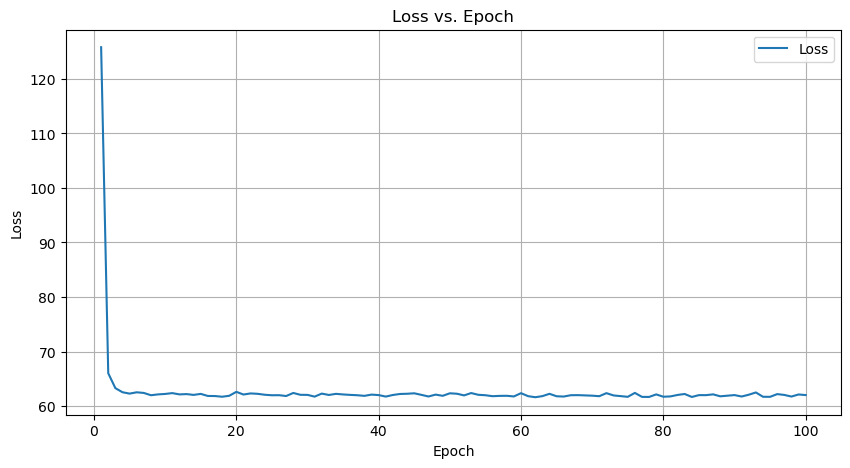

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

gcn_model = CircuitTrainingModel(max_macro_num=PADDING_SIZE, macro_features_dim=4, gcn_node_dim=32)
model = GCN(gcn_model)
dataset = GraphDatase(df)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 

epochs = []
losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        output = model(batch)
        # print(output.shape)
        loss = criterion(output, batch['total_hpwl'])
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    epochs.append(epoch + 1)
    losses.append(total_loss)
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}\r', end='')
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [12]:
torch.save(gcn_model.state_dict(), './save_models/gcn_pretrained_32.pth')
torch.save(gcn_model, './save_models/gcn_pretrained_model_32.pth')

In [13]:
mod = CircuitTrainingModel(max_macro_num=PADDING_SIZE, macro_features_dim=4, gcn_node_dim=32)
mod.load_state_dict(torch.load('./save_models/gcn_pretrained_32.pth'))

<All keys matched successfully>

In [14]:
mod = torch.load('./save_models/gcn_pretrained_model_32.pth')

In [78]:
t = torch.rand(1, 10, 5)
ind = torch.tensor([0, 1])
# get the embeddings where the indexes are ind from t
indexed = t[:, ind]
print(indexed)

tensor([[[0.9010, 0.7802, 0.4878, 0.1822, 0.3014],
         [0.4465, 0.6443, 0.0398, 0.0725, 0.2023]]])


In [81]:
t.repeat(2, 1, 1).shape

torch.Size([2, 10, 5])